In [1]:
import json
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [2]:
# Make notebook's output stable & reproducible across runs

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [3]:
imagenet_labels_processor = lambda x: (x if ',' not in x else x.split(',')[0])

label_mappings = json.load(open('../data/imagenet_class_index.json'))
label_mappings = {int(k): imagenet_labels_processor(v) for k, v in label_mappings.items()}

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT).eval()
        self.normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def forward(self, x):
        # input shape: (batch_size, 3, 224, 224)
        # output shape: (batch_size, 1000)

        x = self.normalize(x)
        x = self.model(x)
        return x

def format_predict(pred):
    pred = pred.squeeze()
    pred = pred.detach().cpu().numpy()
    
    most_likely_idx = pred.argmax()
    confidence = pred[most_likely_idx]
    pred_str = "\"{}\" ({:.2f}% confidence)".format(label_mappings[most_likely_idx], confidence * 100)

    return label_mappings[most_likely_idx], confidence, pred_str

def get_image_prediction(image):
    tensor_img = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
    tensor_img /= 255.0
    output = model(tensor_img)
    output = F.softmax(output, dim=1)
    _, _, prediction_text = format_predict(output)
    return prediction_text

In [4]:
model = Net()
model = model.eval()

A picture of my bird:


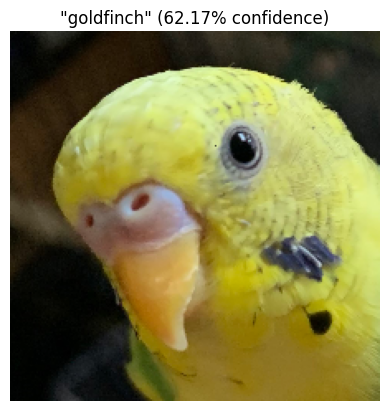

In [5]:
print("A picture of my bird:")

burb_img = cv2.imread('../data/burb.png')[..., ::-1]
burb_img = cv2.resize(burb_img, (224, 224))

prediction_text = get_image_prediction(burb_img)

plt.imshow(burb_img)
plt.title(prediction_text)
plt.axis('off')
plt.show()

['"corkscrew" (1.86% confidence)', '"matchstick" (9.36% confidence)', '"jellyfish" (26.49% confidence)']


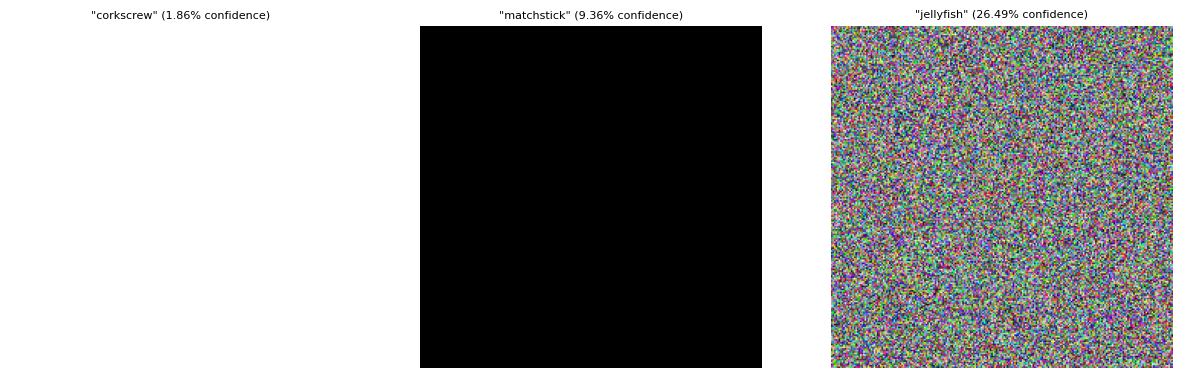

In [6]:
white_img = np.ones((224, 224, 3), dtype=np.uint8) * 255
black_img = np.zeros((224, 224, 3), dtype=np.uint8)
random_img = np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8)

predictions = [ get_image_prediction(img) for img in [white_img, black_img, random_img] ]
print(predictions)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, img in enumerate([white_img, black_img, random_img]):
    ax[i].imshow(img)
    ax[i].set_title(predictions[i])
    ax[i].axis('off')
    ax[i].title.set_fontsize(8)

# Goal
Created a adversarial input that would produce a desired output.

Lets pick a simple target, index `0` of output vector. In this case it should map to `tench`

## Initial Solution

We will first try a naive soluton, we can use usual machine learning methods to optimize a "bad" guess into a "good" guess.

In this solution we will take an all white image and use stochastic gradient descent to optimize for the target class. 

In [7]:
# starting with a white image, our goal is to calculate the error of the model's prediction to the target class
target_output = torch.tensor([0], dtype=torch.long)

# convert the white image to a tensor and normalize it to the same range as the model's input (0-1)
x = torch.tensor(white_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
x.requires_grad = True # allow gradients to be calculated since we want to optimize the image

alpha = 1. # step size for the gradient descent

for iteration in range(15):
    output = model(x)

    # our objective is to maximize the probability of the target class
    # so we'll minimize the negative log probability of the target class
    loss = F.cross_entropy(output, target_output)

    # calculate the gradient of the loss with respect to the input image
    # we don't want to update the model's weights, only the image
    model.zero_grad()
    loss.backward()

    # apply gradient descent to the image, this step is usually done by the optimizer
    # but we're doing it manually here, by taking the gradient of the image and updating it
    x.data = x.data - alpha * x.grad

    # zero the gradient for the next iteration
    x.grad.zero_()

    # clamp the image to the valid pixel range [0, 1]
    x.data = torch.clamp(x.data, 0, 1)


    # in order to get the most accurate prediction, we need to convert the image back to the original format
    # this means converting image to 0-255 integer instead of 0-1 float, we'll lose some precision but it will
    # give us the actual answer to our question, which is to generate an image that the model predicts as the target class
    current_img = (x.squeeze().detach().cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)

    prediction_text = get_image_prediction(current_img)
    print(f"Iter: {iteration: <2} | Loss: {loss.item(): .4f} | Pred: {prediction_text}")

Iter: 0  | Loss:  7.5425 | Pred: "window shade" (5.05% confidence)
Iter: 1  | Loss:  9.2704 | Pred: "dishrag" (3.04% confidence)
Iter: 2  | Loss:  10.1515 | Pred: "nematode" (1.45% confidence)
Iter: 3  | Loss:  7.6952 | Pred: "brain coral" (2.15% confidence)
Iter: 4  | Loss:  5.4389 | Pred: "American alligator" (1.96% confidence)
Iter: 5  | Loss:  4.7709 | Pred: "American alligator" (5.01% confidence)
Iter: 6  | Loss:  3.2306 | Pred: "tench" (10.06% confidence)
Iter: 7  | Loss:  2.2304 | Pred: "brain coral" (17.83% confidence)
Iter: 8  | Loss:  2.4371 | Pred: "tench" (35.66% confidence)
Iter: 9  | Loss:  1.0132 | Pred: "tench" (96.03% confidence)
Iter: 10 | Loss:  0.0390 | Pred: "tench" (99.90% confidence)
Iter: 11 | Loss:  0.0015 | Pred: "tench" (99.92% confidence)
Iter: 12 | Loss:  0.0013 | Pred: "tench" (99.93% confidence)
Iter: 13 | Loss:  0.0012 | Pred: "tench" (99.93% confidence)
Iter: 14 | Loss:  0.0011 | Pred: "tench" (99.94% confidence)


It worked! Lets take a look at the results

#### What does our image look like?

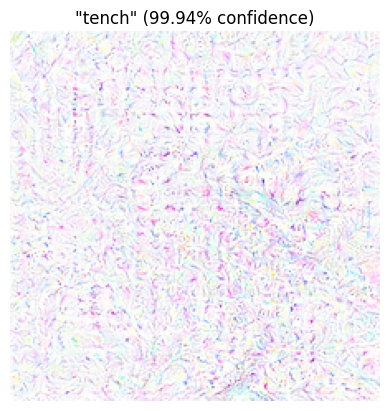

In [8]:
plt.imshow(current_img)
plt.title(prediction_text)
plt.axis('off')
plt.show()

#### How different is the image from the original white image?

In [9]:
diff = np.abs(white_img - current_img)
max_diff, mean_diff, min_diff = diff.max(), diff.mean(), diff.min()

print(f"Max difference:  {max_diff:.2f}")
print(f"Mean difference: {mean_diff:.2f}")
print(f"Min difference:  {min_diff:.2f}")

Max difference:  209.00
Mean difference: 14.36
Min difference:  0.00


There is a large difference... can we do better?

### Optimizing for target class & low difference

Seeing as there's a very large visual difference between a white image and the output image we got, lets try to see if we can still achieve the same target class with a lower difference.

There's a couple of ways we can optimize for this, lets go through a few solutions, taking our previous code as an example

In [10]:
target_output = torch.tensor([0], dtype=torch.long)

white_img_tensor = torch.tensor(white_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0

x = torch.tensor(white_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
x.requires_grad = True

alpha = 1.

# lets create a new variable, epsilon, to control the amount of difference between the current image and the white image
# this will allow us to control the amount of noise that we add to the image
# for this example lets say we don't want the difference to be more than 10 pixel difference compared to the white image
# we will also divide the epsilon by 255 to normalize it to the same range as the x tensor
epsilon = 10. / 255.

for iteration in range(50):
    output = model(x)

    loss = F.cross_entropy(output, target_output)

    model.zero_grad()
    loss.backward()

    x.data = x.data - alpha * x.grad

    x.grad.zero_()

    x.data = torch.clamp(x.data, 0, 1)
    
    # we will also clamp the difference between the current image and the white image
    # this will ensure that the image is always within the valid pixel range
    x.data = torch.clamp(x.data, white_img_tensor - epsilon, white_img_tensor + epsilon)

    current_img = (x.squeeze().detach().cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)

    prediction_text = get_image_prediction(current_img)

    # adding print statements to see the difference between the current image and the white image
    diff = np.abs(white_img - current_img)
    max_diff, mean_diff, min_diff = diff.max(), diff.mean(), diff.min()

    print(
        f"Iter: {iteration: <2} | Loss: {loss.item(): .4f} "
        f"| Min/Max/Mean diff: {min_diff:.2f}/{max_diff:.2f}/{mean_diff:.2f} "
        f"| Pred: {prediction_text}"
    )

Iter: 0  | Loss:  7.5425 | Min/Max/Mean diff: 0.00/10.00/1.39 | Pred: "window shade" (3.81% confidence)
Iter: 1  | Loss:  9.1152 | Min/Max/Mean diff: 0.00/10.00/3.73 | Pred: "bath towel" (2.34% confidence)
Iter: 2  | Loss:  9.4835 | Min/Max/Mean diff: 0.00/10.00/4.48 | Pred: "screw" (3.01% confidence)
Iter: 3  | Loss:  8.9104 | Min/Max/Mean diff: 0.00/10.00/4.79 | Pred: "broom" (2.33% confidence)
Iter: 4  | Loss:  8.1987 | Min/Max/Mean diff: 0.00/10.00/4.96 | Pred: "whistle" (2.07% confidence)
Iter: 5  | Loss:  8.3175 | Min/Max/Mean diff: 0.00/10.00/5.09 | Pred: "handkerchief" (1.93% confidence)
Iter: 6  | Loss:  7.6980 | Min/Max/Mean diff: 0.00/10.00/5.15 | Pred: "handkerchief" (3.51% confidence)
Iter: 7  | Loss:  7.8992 | Min/Max/Mean diff: 0.00/10.00/5.19 | Pred: "screw" (1.19% confidence)
Iter: 8  | Loss:  7.7744 | Min/Max/Mean diff: 0.00/10.00/5.21 | Pred: "bath towel" (15.22% confidence)
Iter: 9  | Loss:  7.9369 | Min/Max/Mean diff: 0.00/10.00/5.14 | Pred: "kite" (2.65% confidenc

Why is our result so bad? Even after 50 iterations we still have a almost same loss as what we started with.

Well we are using a very simple way to update the gradients and it is very prone to *oscillation*. We are also clamping results which is also contributing to the oscillation.

We need to reduce the learning rate.

In [11]:
target_output = torch.tensor([0], dtype=torch.long)

white_img_tensor = torch.tensor(white_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0

x = torch.tensor(white_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
x.requires_grad = True

# reduced from 1 to 0.1
alpha = 0.1

epsilon = 10. / 255.

for iteration in range(25):
    output = model(x)

    loss = F.cross_entropy(output, target_output)

    model.zero_grad()
    loss.backward()

    x.data = x.data - alpha * x.grad

    x.grad.zero_()
    x.data = torch.clamp(x.data, 0, 1)
    x.data = torch.clamp(x.data, white_img_tensor - epsilon, white_img_tensor + epsilon)

    current_img = (x.squeeze().detach().cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    prediction_text = get_image_prediction(current_img)

    diff = np.abs(white_img - current_img)
    max_diff, mean_diff, min_diff = diff.max(), diff.mean(), diff.min()

    print(
        f"Iter: {iteration: <2} | Loss: {loss.item(): .4f} "
        f"| Min/Max/Mean diff: {min_diff:.2f}/{max_diff:.2f}/{mean_diff:.2f} "
        f"| Pred: {prediction_text}"
    )

Iter: 0  | Loss:  7.5425 | Min/Max/Mean diff: 0.00/4.00/0.51 | Pred: "corkscrew" (1.76% confidence)
Iter: 1  | Loss:  7.4247 | Min/Max/Mean diff: 0.00/10.00/0.67 | Pred: "corkscrew" (1.45% confidence)
Iter: 2  | Loss:  7.8976 | Min/Max/Mean diff: 0.00/10.00/0.88 | Pred: "ski" (1.38% confidence)
Iter: 3  | Loss:  7.8823 | Min/Max/Mean diff: 0.00/10.00/1.11 | Pred: "ski" (1.74% confidence)
Iter: 4  | Loss:  7.5663 | Min/Max/Mean diff: 0.00/10.00/1.34 | Pred: "ski" (2.05% confidence)
Iter: 5  | Loss:  6.6579 | Min/Max/Mean diff: 0.00/10.00/1.57 | Pred: "snowmobile" (2.57% confidence)
Iter: 6  | Loss:  6.3951 | Min/Max/Mean diff: 0.00/10.00/1.82 | Pred: "envelope" (3.24% confidence)
Iter: 7  | Loss:  6.9340 | Min/Max/Mean diff: 0.00/10.00/2.11 | Pred: "spider web" (1.73% confidence)
Iter: 8  | Loss:  6.3351 | Min/Max/Mean diff: 0.00/10.00/2.31 | Pred: "whistle" (4.70% confidence)
Iter: 9  | Loss:  5.5793 | Min/Max/Mean diff: 0.00/10.00/2.48 | Pred: "spider web" (6.55% confidence)
Iter: 10 

Our model learned! We have max pixel difference of 10 and we are still able to create an adversarial image.

Lets see what this image looks like

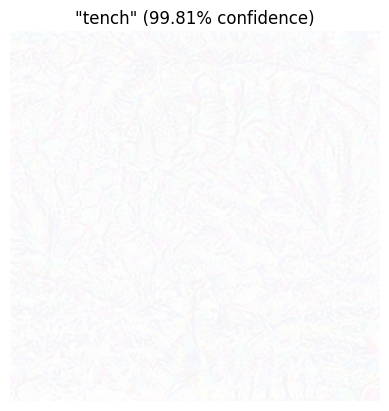

In [12]:
plt.imshow(current_img)
plt.title(prediction_text)
plt.axis('off')
plt.show()

Compared to an all white image, we can still tell the difference that this image is not like the original one we started with.

But if we started with more of a complex image, we will barely tell the difference.

### Adversarial Attack on a Bird Image

Lets try to get the model to classify the bird image to target index `413`, `assault rifle, assault gun`.

In [13]:
target_output = torch.tensor([413], dtype=torch.long)

burb_img_tensor = torch.tensor(burb_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0

x = torch.tensor(burb_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
x.requires_grad = True

alpha = 0.1

# lets lower the epsilon to a lower pixel difference
epsilon = 1. / 255.

for iteration in range(10):
    output = model(x)

    loss = F.cross_entropy(output, target_output)

    model.zero_grad()
    loss.backward()

    x.data = x.data - alpha * x.grad

    x.grad.zero_()
    x.data = torch.clamp(x.data, 0, 1)
    x.data = torch.clamp(x.data, burb_img_tensor - epsilon, burb_img_tensor + epsilon)

    current_img = (x.squeeze().detach().cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    prediction_text = get_image_prediction(current_img)

    # changed types as uint8 underflows when subtracting
    diff = np.abs(burb_img.astype(np.int32) - current_img.astype(np.int32))
    max_diff, mean_diff, min_diff = diff.max(), diff.mean(), diff.min()

    print(
        f"Iter: {iteration: <2} | Loss: {loss.item(): .4f} "
        f"| Min/Max/Mean diff: {min_diff:.2f}/{max_diff:.2f}/{mean_diff:.2f} "
        f"| Pred: {prediction_text}"
    )

Iter: 0  | Loss:  13.4382 | Min/Max/Mean diff: 0.00/2.00/0.76 | Pred: "puffer" (5.17% confidence)
Iter: 1  | Loss:  8.1450 | Min/Max/Mean diff: 0.00/2.00/0.70 | Pred: "goose" (6.03% confidence)
Iter: 2  | Loss:  4.7022 | Min/Max/Mean diff: 0.00/2.00/0.73 | Pred: "assault rifle" (4.97% confidence)
Iter: 3  | Loss:  2.8506 | Min/Max/Mean diff: 0.00/2.00/0.75 | Pred: "assault rifle" (15.59% confidence)
Iter: 4  | Loss:  1.6048 | Min/Max/Mean diff: 0.00/2.00/0.77 | Pred: "assault rifle" (24.72% confidence)
Iter: 5  | Loss:  1.1955 | Min/Max/Mean diff: 0.00/2.00/0.77 | Pred: "assault rifle" (64.57% confidence)
Iter: 6  | Loss:  0.3494 | Min/Max/Mean diff: 0.00/2.00/0.71 | Pred: "assault rifle" (88.91% confidence)
Iter: 7  | Loss:  0.0869 | Min/Max/Mean diff: 0.00/2.00/0.66 | Pred: "assault rifle" (88.80% confidence)
Iter: 8  | Loss:  0.0470 | Min/Max/Mean diff: 0.00/2.00/0.66 | Pred: "assault rifle" (90.01% confidence)
Iter: 9  | Loss:  0.0376 | Min/Max/Mean diff: 0.00/2.00/0.66 | Pred: "as

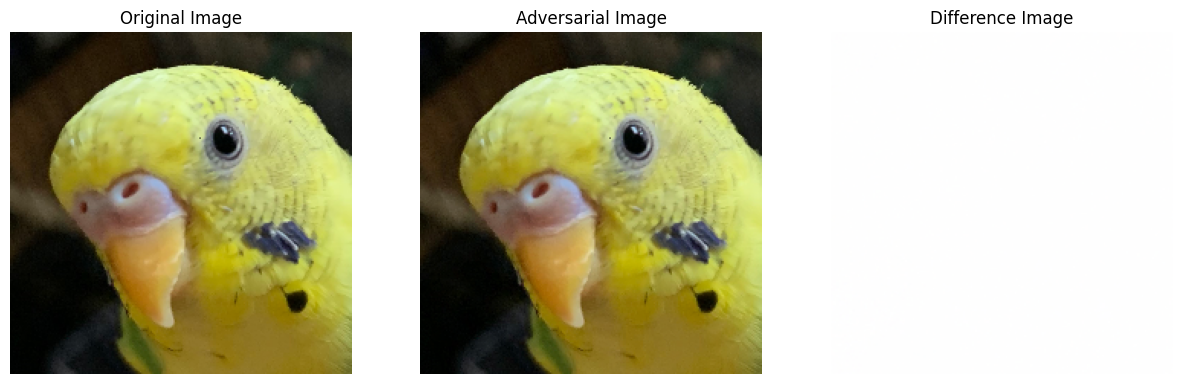

Original Image Prediciton:
"goldfinch" (62.17% confidence)

Adversarial Image Prediction:
"assault rifle" (91.72% confidence)


In [14]:
delta_img = np.abs(burb_img.astype(np.int32) - current_img.astype(np.int32)).astype(np.uint8)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Original Image", "Adversarial Image", "Difference Image"]
images = [burb_img, current_img, ~delta_img]

for i in range(3):
    ax[i].imshow(images[i])
    ax[i].set_title(titles[i])
    ax[i].axis('off')

plt.show()

print("Original Image Prediciton:")
print(get_image_prediction(burb_img))

print()

print("Adversarial Image Prediction:")
print(get_image_prediction(current_img))

## Fast Gradient Signed Method (FGSM) Solution

Lets modify our code to try to apply FGSM. In this attack, we calculate a gradient based on a loss function to our targeted class, and apply a small epsilon in that the direction of the sign of the gradient.

$$
\text{Adversarial example: } X_{\text{adv}} = X + \epsilon \cdot \text{sign}(\nabla_X J(\theta, X, y))
$$

Where:
\begin{align*}
& X_{\text{adv}} \text{ is the adversarial example,} \\
& X \text{ is the original input image,} \\
& \epsilon \text{ is the perturbation magnitude,} \\
& \nabla_X J(\theta, X, y) \text{ is the gradient of the loss function } J \text{ with respect to } X \text{ evaluated at } X, \\
& \theta \text{ represents the model parameters, and} \\
& y \text{ is the true label of } X.
\end{align*}
$$


In [15]:
target_output = torch.tensor([0], dtype=torch.long) # we will target index 0, which is "tench, Tinca tinca"

burb_img_tensor = torch.tensor(burb_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0

x = torch.tensor(burb_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
x.requires_grad = True

epsilon = 2. / 255.

output = model(x)
loss = -F.cross_entropy(output, target_output)

model.zero_grad()
loss.backward()

grad = x.grad.data

x_adv = x + epsilon * grad.sign()
x_adv = torch.clamp(x_adv, 0, 1)

current_img = (x_adv.squeeze().detach().cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
prediction_text = get_image_prediction(current_img)

diff = np.abs(burb_img.astype(np.int32) - current_img.astype(np.int32))
max_diff, mean_diff, min_diff = diff.max(), diff.mean(), diff.min()

print(
    f"Loss: {loss.item(): .4f} "
    f"| Min/Max/Mean diff: {min_diff:.2f}/{max_diff:.2f}/{mean_diff:.2f} "
    f"| Pred: {prediction_text}"
)

Loss: -9.0888 | Min/Max/Mean diff: 0.00/3.00/2.00 | Pred: "tench" (29.52% confidence)


### Disclaimer

FGSM does not run any interations and it is sensative to epsilon and input image. Depending on input image & target class, it may FSGM might not be the best method but it is a good start.

Lets see what the images look like

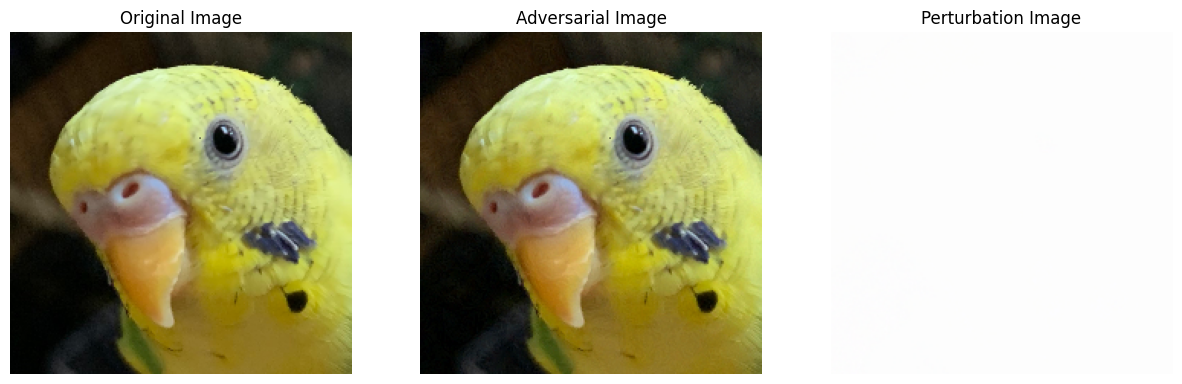

Original Image Prediciton:
"goldfinch" (62.17% confidence)

Adversarial Image Prediction:
"tench" (29.52% confidence)


In [16]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Original Image", "Adversarial Image", "Perturbation Image"]
images = [burb_img, current_img, ~diff.astype(np.uint8)]

for i in range(3):
    ax[i].imshow(images[i])
    ax[i].set_title(titles[i])
    ax[i].axis('off')

plt.show()

print("Original Image Prediciton:")
print(get_image_prediction(burb_img))

print()

print("Adversarial Image Prediction:")
print(get_image_prediction(current_img))

## Projected Gradient Descent (PGD) Solution

Lets modify our code to try to apply PGD. At a high level this attack is basically iterative FGSM. Instead of applying the perturbation once, we will take small steps into the sign of the gradient.

$$
\text{Initialize } X^{(0)} = X \text{ and set } t = 0
$$

Repeat until convergence or maximum iterations:
$$
\begin{align*}
& X^{(t+1)} = \text{Clip}(X^{(t)} + \alpha \cdot \text{sign}(\nabla_X J(\theta, X^{(t)}, y)), \epsilon) \\
& t = t + 1
\end{align*}
$$

Where:
\begin{align*}
& X^{(t)} \text{ is the image at iteration } t, \\
& X \text{ is the original input image,} \\
& \epsilon \text{ is the perturbation limit,} \\
& \alpha \text{ is the step size,} \\
& \text{Clip}(x, \epsilon) \text{ clips } x \text{ to be within } \epsilon \text{ of } X, \\
& \nabla_X J(\theta, X^{(t)}, y) \text{ is the gradient of the loss function } J \text{ with respect to } X \text{ evaluated at } X^{(t)}, \\
& \theta \text{ represents the model parameters, and} \\
& y \text{ is the true label of } X.
\end{align*}
$$


In [17]:
target_output = torch.tensor([413], dtype=torch.long) # we will target index 413, which is "assault rifle, assault gun"

burb_img_tensor = torch.tensor(burb_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0

x = torch.tensor(burb_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
x.requires_grad = True

epsilon =   5. / 255. # we will allow a maximum of 5 pixel difference
alpha =     1. / 255. # step size at each iteration (how many pixels to move each iteration)

for iteration in range(10):
    output = model(x)
    loss = F.cross_entropy(output, target_output)

    model.zero_grad()
    loss.backward()

    x.data = x.data - alpha * x.grad.sign()
    x.data = torch.clamp(x.data, 0, 1)
    x.data = torch.clamp(x.data, burb_img_tensor - epsilon, burb_img_tensor + epsilon)

    current_img = (x.squeeze().detach().cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    prediction_text = get_image_prediction(current_img)

    # changed types as uint8 underflows when subtracting
    diff = np.abs(burb_img.astype(np.int32) - current_img.astype(np.int32))
    max_diff, mean_diff, min_diff = diff.max(), diff.mean(), diff.min()

    print(
        f"Iter: {iteration: <2} | Loss: {loss.item(): .4f} "
        f"| Min/Max/Mean diff: {min_diff:.2f}/{max_diff:.2f}/{mean_diff:.2f} "
        f"| Pred: {prediction_text}"
    )

Iter: 0  | Loss:  13.4382 | Min/Max/Mean diff: 0.00/2.00/1.00 | Pred: "puffer" (5.08% confidence)
Iter: 1  | Loss:  8.0757 | Min/Max/Mean diff: 0.00/3.00/1.75 | Pred: "muzzle" (3.38% confidence)
Iter: 2  | Loss:  4.8234 | Min/Max/Mean diff: 0.00/3.00/2.55 | Pred: "assault rifle" (15.30% confidence)
Iter: 3  | Loss:  1.8669 | Min/Max/Mean diff: 0.00/4.00/3.22 | Pred: "assault rifle" (68.43% confidence)
Iter: 4  | Loss:  0.3802 | Min/Max/Mean diff: 0.00/5.00/4.04 | Pred: "assault rifle" (84.15% confidence)
Iter: 5  | Loss:  0.1732 | Min/Max/Mean diff: 0.00/6.00/4.18 | Pred: "assault rifle" (90.14% confidence)
Iter: 6  | Loss:  0.1038 | Min/Max/Mean diff: 0.00/6.00/4.42 | Pred: "assault rifle" (92.51% confidence)
Iter: 7  | Loss:  0.0781 | Min/Max/Mean diff: 0.00/6.00/4.55 | Pred: "assault rifle" (94.01% confidence)
Iter: 8  | Loss:  0.0620 | Min/Max/Mean diff: 0.00/6.00/4.69 | Pred: "assault rifle" (95.16% confidence)
Iter: 9  | Loss:  0.0498 | Min/Max/Mean diff: 0.00/6.00/4.75 | Pred: "

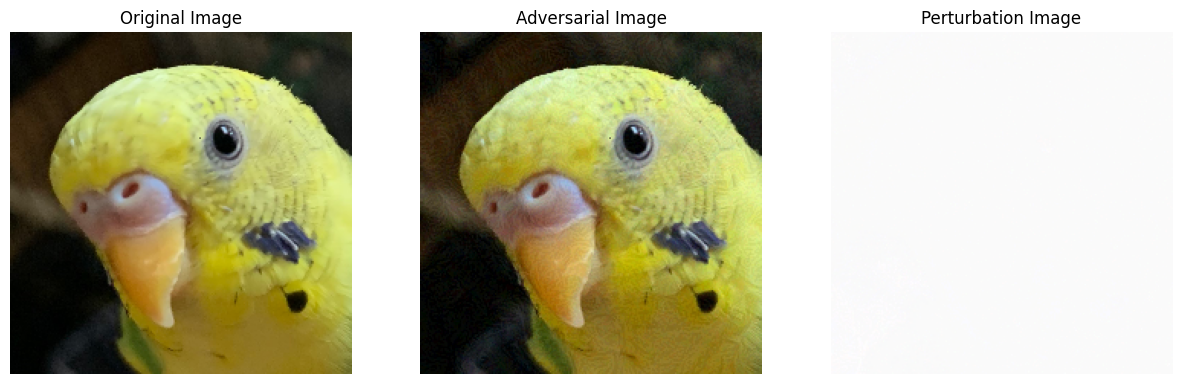

Original Image Prediciton:
"goldfinch" (62.17% confidence)

Adversarial Image Prediction:
"assault rifle" (96.24% confidence)


In [18]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Original Image", "Adversarial Image", "Perturbation Image"]
images = [burb_img, current_img, ~diff.astype(np.uint8)]

for i in range(3):
    ax[i].imshow(images[i])
    ax[i].set_title(titles[i])
    ax[i].axis('off')

plt.show()

print("Original Image Prediciton:")
print(get_image_prediction(burb_img))

print()

print("Adversarial Image Prediction:")
print(get_image_prediction(current_img))